In [93]:
import numpy as np
from collections import UserDict
import torch
import gymnasium as gymnasium
import gym
import matplotlib.pyplot as plt

import pybulletgym

import Evaluation
import ReplayBuffer
import TD3

In [94]:
#Parameters for TD3 algorithm
START_TIMESTEPS = 10000
EVALUATION_FREQUENCY = 5000
MAX_TIMESTEPS = 1000000
EXPLORATION_NOISE = 0.1
BATCH_SIZE = 100
DISCOUNT = 0.99
TAU = 0.005
POLICY_NOISE = 0.2
NOISE_CLIP = 0.5
POLICY_FREQUENCY = 2
LEARNING_RATE = 0.001
BUFFER_SIZE = 1000000

In [ ]:
#Run this command to execute algorithm without window
env = gymnasium.make("Walker2d-v4")

#Run with window mode - more memory usage
#env = gymnasium.make("Walker2d-v4", "Humanoid")

# pybullet environment
# env = gym.make("Walker2DBulletEnv-v0")

In [95]:
torch.manual_seed(0)
np.random.seed(0)

observation_dimension = env.observation_space.shape[0]
action_dimension = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

#Create an instance for TD3 algorithm
td3 = TD3.TD3(
    observation_dimension,
    action_dimension,
    max_action,
    DISCOUNT,
    TAU,
    POLICY_NOISE,
    NOISE_CLIP,
    POLICY_FREQUENCY,
    LEARNING_RATE
)

    
#Initialize replay buffer
replay_buffer = ReplayBuffer.ReplayBuffer(observation_dimension, action_dimension, BUFFER_SIZE)

# Start evaluation from policy without training by TD3
evaluations = [Evaluation.evaluate_algorithm(env, td3, 100)]

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_id = 0

# Start learning
for t in range(int(MAX_TIMESTEPS)):
    
    episode_timesteps += 1

    if t < START_TIMESTEPS:
        #Random action for exploration phase
        action = env.action_space.sample()
    else:	
        if (len(state) == 2):
            state_to_pass = state[0]
        else:
            state_to_pass = state
        
        action = (
            td3.select_action(np.array(state_to_pass))
            + np.random.normal(0, max_action * EXPLORATION_NOISE, size=action_dimension)
        ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done, additional_var, additional_var2 = env.step(action) 
    done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0
    
    # Add data to replay buffer
    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    # Start training after exploration phase
    if t >= START_TIMESTEPS:
        td3.train(replay_buffer, BATCH_SIZE)


    #Print information about episode including reward, timesteps and reset variables
    if done: 
        print(f"Episode Id: {episode_id+1}, Episode Reward: {episode_reward:.3f}, Total Timesteps: {t+1}")
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_id += 1

    #Evaluate algorithm after certain period
    if (t+1) % EVALUATION_FREQUENCY == 0:
        evaluations.append(Evaluation.evaluate_algorithm(env, td3, 100))
        
env.close()

test
---------------------------------------
Evaluation over 100 episodes: 3.364
---------------------------------------
Episode Id: 1, Total Timesteps: 21,  Episode Reward: 7.422
Episode Id: 2, Total Timesteps: 34,  Episode Reward: 0.796
Episode Id: 3, Total Timesteps: 70,  Episode Reward: 6.889
Episode Id: 4, Total Timesteps: 100,  Episode Reward: 7.021
Episode Id: 5, Total Timesteps: 117,  Episode Reward: 2.911
Episode Id: 6, Total Timesteps: 129,  Episode Reward: -0.505
Episode Id: 7, Total Timesteps: 186,  Episode Reward: 25.697
Episode Id: 8, Total Timesteps: 202,  Episode Reward: -2.738
Episode Id: 9, Total Timesteps: 222,  Episode Reward: 3.154
Episode Id: 10, Total Timesteps: 239,  Episode Reward: -2.147
Episode Id: 11, Total Timesteps: 269,  Episode Reward: 12.515
Episode Id: 12, Total Timesteps: 279,  Episode Reward: 0.473
Episode Id: 13, Total Timesteps: 299,  Episode Reward: 2.152
Episode Id: 14, Total Timesteps: 327,  Episode Reward: 1.156
Episode Id: 15, Total Timesteps:

In [ ]:
evaluations = evaluations[1:]

In [ ]:
x = np.array(np.arange(0, MAX_TIMESTEPS - 5000, EVALUATION_FREQUENCY))
y = np.array(evaluations)

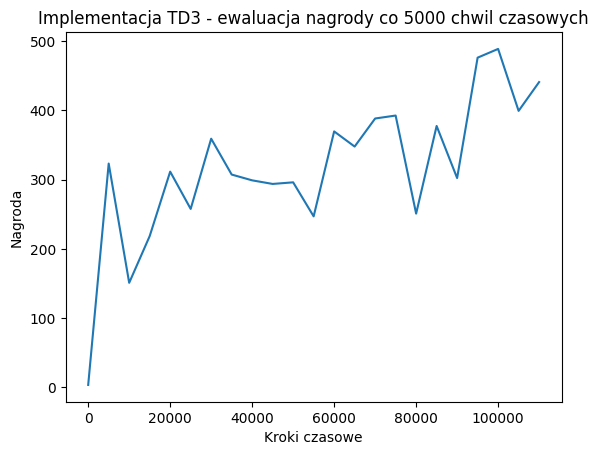

In [ ]:
plt.plot(x, y)
plt.xlabel('Kroki czasowe')
plt.ylabel('Nagroda')
plt.title('Implementacja TD3 - ewaluacja nagrody co 5000 chwil czasowych')
plt.show()